<a href="https://colab.research.google.com/github/josephkimbugwe/agentic_RAG/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install langchain
# !pip install openai
# !pip install google-search-results
# !pip install tiktoken wikipedia huggingface_hub
# !pip install -U langchain-community
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [ ]:
import os
import openai
import langchain
from dotenv import load_dotenv
load_dotenv('.env')
env_path = "/content/drive/My Drive/Colab Notebooks/.env"

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
SERPAPI_API_KEY = os.getenv("SERPAPI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [ ]:
from typing import List, Optional
from pydantic import BaseModel, Field
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser, JsonKeyOutputFunctionsParser

In [ ]:
from langchain_openai import OpenAIEmbeddings
#embedding model
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [ ]:
#!gdown 1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW

Downloading...
From (original): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW
From (redirected): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW&confirm=t&uuid=dc4becf8-fc0f-4a11-9272-0711e1f7945c
To: /content/drive/MyDrive/Colab Notebooks/simplewiki-2020-11-01.jsonl.gz
100% 50.2M/50.2M [00:01<00:00, 25.6MB/s]


In [ ]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = 'simplewiki-2020-11-01.jsonl.gz'
docs = []

with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        # Add documents
        docs.append({
            'metadata': {
                'title': data.get('title'),
                'article_id': data.get('id')
            },
            'data': ' '.join(data.get('paragraphs')[0:3])  # restrict data to first 3 paragraphs to run later modules faster
        })

# We subset our data to use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs for x in ['india']
        if x in doc['data'].lower().split()]

# Create docs
docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]

# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

chunked_docs[:3]


[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

In [ ]:
from langchain_chroma import Chroma

# Create vector DB of docs and embeddings - takes <30s on Colab
chroma_db = Chroma.from_documents(
    documents=chunked_docs,
    collection_name='rag_wikipedia_db',
    embedding=openai_embed_model,
    # Need to set the distance function to cosine; else it uses Euclidean by default
    # Check: https://docs.trychroma.com/guides#changing-the-distance-function
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory="./wikipedia_db"
)


In [ ]:
similarity_threshold_retriever = chroma_db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "k": 3,
        "score_threshold": 0.3
    }
)

# We can then test if our retriever is working on some sample queries
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs


[Document(id='d0318301-abda-4329-85e3-ca5ad6fcbae7', metadata={'title': 'New Delhi', 'article_id': '5117'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(id='59081301-01c9-41c3-95d9-4450f94602c7', metadata={'title': 'Mumbai', 'article_id': '5114'}, page_content="Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, i

In [ ]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM for grading
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
Follow these instructions for grading:
  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
{document}
User question:
{question}
"""),
    ]
)

# Build grader chain
doc_grader = grade_prompt | structured_llm_grader


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  

In [ ]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)

for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({
        "question": query,
        "document": doc.page_content
    }))
    print()


New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: binary_score='yes'

Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million people. The seven islands that form Bombay were home to fishing colonies. The islands were ruled by successive kingdoms and indigenous em

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If no context is present or if you don't know the answer, just say that you don't know the answer.
Do not make up the answer unless it is there in the provided context.
Give a detailed answer and to the point answer with regard to the question.

Question:
{question}

Context:
{context}

Answer:
"""
prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create QA RAG chain
qa_rag_chain = (
    {
        "context": (
            itemgetter('context') |
            RunnableLambda(format_docs)
        ),
        "question": itemgetter('question')
    }
    |
    prompt_template
    |
    chatgpt
    |
    StrOutputParser()
)


In [ ]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
  {"context": top3_docs, "question": query}
)
print(result)

The capital of India is New Delhi.


In [ ]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
- Convert the following input question to a better version that is optimized for web search.
- When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        (
            "human",
            """Here is the initial question:
{question}
Formulate an improved question.
""",
        ),
    ]
)

# Create rephraser chain
question_rewriter = (
    re_write_prompt |
    llm |
    StrOutputParser()
)


In [ ]:
query = "who won the champions league in 2024?"
question_rewriter.invoke({"question": query})

'Who was the winner of the 2024 UEFA Champions League?'

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)

/tmp/ipython-input-3206506337.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)


In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]


In [ ]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)

    return {"documents": documents, "question": question}


In [ ]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.
    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"
    return {"documents": filtered_docs, "question": question,
            "web_search_needed": web_search_needed}


In [ ]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


In [ ]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}


In [ ]:
def generate_answer(state):
    """
    Generate answer from context document using LLM
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question,
            "generation": generation}


In [ ]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]
    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"


In [ ]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()


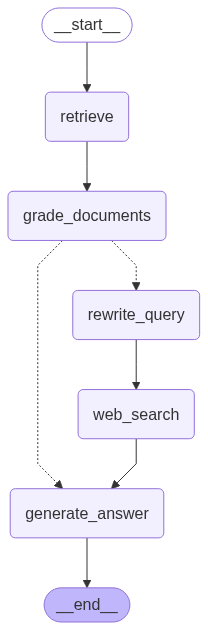

In [ ]:
from IPython.display import Image, display, Markdown
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [ ]:
query = "what is the capital of India?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [ ]:
display(Markdown(response['generation']))

The capital city of India is New Delhi. It is a part of the National Capital Territory of Delhi and serves as the seat of all three branches of the Government of India, including the Rashtrapati Bhavan, Sansad Bhavan, and the Supreme Court. New Delhi was declared the capital of India on December 12, 1912, during the presence of George V.

In [ ]:
query = "who won the champions league in 2024?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [ ]:
display(Markdown(response['generation']))

The winners of the 2024 UEFA Champions League were Real Madrid.

In [ ]:
query = "Tell me about India"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---
